# 🧠 Credit Card Fraud Detection Project 

# Step 1: Import Libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


# Step 2: Load Dataset

In [19]:
df = pd.read_csv('creditcard.csv/creditcard.csv')  # Make sure this file is in the same directory
print("Dataset shape:", df.shape)
print(df['Class'].value_counts(normalize=True))

Dataset shape: (284807, 31)
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


# Step 3: Visualize Class Distribution

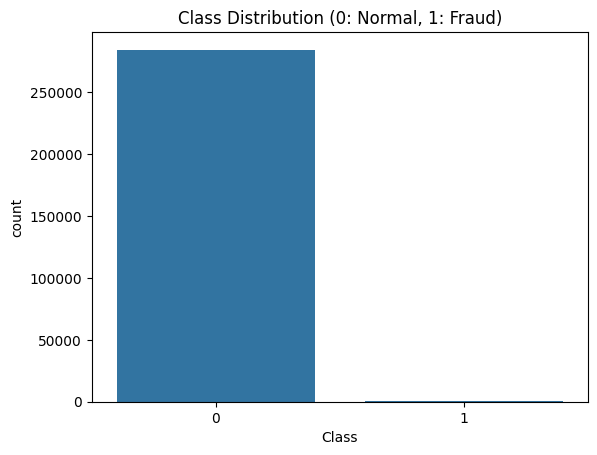

In [20]:
sns.countplot(data=df, x='Class')
plt.title("Class Distribution (0: Normal, 1: Fraud)")
plt.show()

# Step 4: Feature Engineering

In [21]:
df['Hour'] = df['Time'] // 3600
df['Amount_log'] = np.log1p(df['Amount'])
df['Is_Weekend'] = ((df['Time'] // 86400) % 7 >= 5).astype(int)
df['Is_Night'] = ((df['Hour'] <= 6) | (df['Hour'] >= 23)).astype(int)

# Step 5: Preprocess and Scale

In [22]:
features = df.drop(['Class', 'Time'], axis=1)
target = df['Class']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Balance the Data with SMOTE

In [23]:
smote = SMOTE(random_state=42, sampling_strategy=0.1)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

print("After SMOTE:", np.bincount(y_train_bal))

After SMOTE: [227451  22745]


# Step 7: Logistic Regression

In [24]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train_bal, y_train_bal)

y_pred = lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1]))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.91      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.97      0.99     56962

AUC: 0.9733102899291399


# Step 8: Random Forest

In [25]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)
rf.fit(X_train_bal, y_train_bal)

y_pred_rf = rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.44      0.86      0.58        98

    accuracy                           1.00     56962
   macro avg       0.72      0.93      0.79     56962
weighted avg       1.00      1.00      1.00     56962

AUC: 0.9826490774981911


# Step 9: Feature Importances

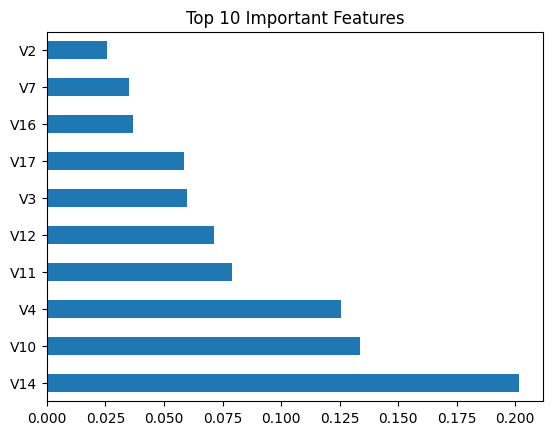

In [26]:
importances = pd.Series(rf.feature_importances_, index=features.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()

# Step 10: Risk Scoring

In [27]:
probs = rf.predict_proba(X_test_scaled)[:, 1]
risk_bins = pd.cut(probs, bins=[0, 0.1, 0.3, 0.7, 1.0], labels=['Low', 'Medium', 'High', 'Critical'])

risk_df = pd.DataFrame({
    'Risk_Score': probs,
    'Risk_Category': risk_bins,
    'Prediction': rf.predict(X_test_scaled),
    'Actual': y_test.reset_index(drop=True)
})

print(risk_df['Risk_Category'].value_counts())
risk_df.head()

Risk_Category
Low         52881
Medium       3526
High          443
Critical      111
Name: count, dtype: int64


,Risk_Score,Risk_Category,Prediction,Actual
0,0.007587,Low,0,0
1,0.011109,Low,0,0
2,0.105579,Medium,0,0
3,0.003985,Low,0,0
4,0.257878,Medium,0,0
